# Cal-CRAI Index: Climate Domain

**Order of operations**:
- Metric handling
   - Retrieve data
   - Min-max standardization
   - Set vulnerability orientation (pos for vulnerable, neg for resilience)
- Calculate indicators
   - Calculate products for non weighted and weighted climate risk scenarios
   - Min-max standardization
- Calculate domain score
- Visualizations

Note: Functions and figures within this notebook are in development

In [1]:
import pandas as pd
import os
import sys
import warnings
import numpy as np

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plots import plot_domain, plot_region_domain
from scripts.utils.calculate_index import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats, compute_summed_climate_indicators)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


## Create a new folder for pulled climate data
* last columns from each climate metric file are isolated
* set island tract data to NaN
* merge all metric columns together based on GEOID

In [3]:
# domain-specific
domain_prefix = 'climate_'
input_folder = r'aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'../utils/calcrai_metrics.csv'
meta_csv = r'C:/Users/jespi/eagle/carb-climate-index-4/scripts/utils/calcrai_metrics.csv'
merged_output_file = f'concatenate_{domain_prefix}metrics.csv'

metric_vulnerable_resilient_dict = process_domain_csv_files(domain_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 33 CSV files within climate_domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_climate_metrics.csv


### Now, take a look at the merged singluar csv file

In [4]:
# read-in and view processed data
pd.set_option('display.max_columns', None)
cleaned_climate_df = pd.read_csv(merged_output_file)
cleaned_climate_df

,GEOID,drought_coverage_percentage,drought_crop_loss_acres,drought_crop_loss_indemnity_amount,change_in_drought_years,percent_weeks_drought,mean_change_annual_heat_days,mean_change_annual_warm_nights,floodplain_percentage,avg_flood_insurance_payout_per_claim,estimated_flood_crop_loss_cost,precip_99percentile,surface_runoff,total_flood_fatalities,median_flood_warning_days,mean_change_cold_days,heat_crop_loss_acres,heat_crop_loss_indemnity_amount,avg_age_adjust_heat_hospitalizations_per_10000,median_heat_warning_days,slr_vulnerable_building_content_cost,fire_stations_count_diff,hospitals_count_diff,police_stations_count_diff,schools_count_diff,building_exposed_slr_count,slr_vulnerability_delta_percentage_change,slr_vulnerable_wastewater_treatment_count,rcp_4.5__50th_percent_change,burn_area_m2,change_ffwi_days,average_damaged_destroyed_structures_wildfire,average_annual_fatalities_wildfire,median_red_flag_warning_days
0,6001400100,37.984370,197.583333,7394.25,3.500000,0.570255,2.683333,17.908333,NaN,5463.8925,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,2.0,650084.0,3.0,0.0,1.0,14.0,1315.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,3.5
1,6001400200,37.984370,197.583333,7394.25,3.500000,0.570255,2.766667,18.758333,NaN,NaN,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,1.0,434115.0,3.0,0.0,1.0,14.0,775.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
2,6001400300,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,2600.0000,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,922941.0,3.0,0.0,1.0,14.0,1941.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
3,6001400400,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,NaN,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,594158.0,3.0,0.0,1.0,14.0,1328.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
4,6001400500,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,2625.3700,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,398157.0,3.0,0.0,1.0,14.0,1057.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,38.971624,NaN,NaN,10.000000,0.571168,9.284259,10.201852,0.02,NaN,0.0,0.649380,0.018775,3.0,1.0,-3.433333,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-38172.890,-1.183333,22.0,0.0,4.0
9125,6115041001,38.971624,NaN,NaN,10.750000,0.571168,8.808889,9.591389,45.42,NaN,0.0,0.547662,0.082888,3.0,2.0,-3.268750,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-51149.184,-1.777083,22.0,0.0,4.0
9126,6115041002,38.971624,NaN,NaN,10.125000,0.571168,9.257895,9.825877,5.96,NaN,0.0,1.119589,0.337733,3.0,2.0,-3.354167,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10727.109,-1.762500,22.0,0.0,5.5
9127,6115041101,38.971624,NaN,NaN,8.333333,0.571168,9.950170,10.663265,0.33,NaN,0.0,2.578545,1.122988,3.0,4.0,-2.929167,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,966470.400,-0.556944,22.0,0.0,8.5


# Handle sea level rise data metrics

### Step 1) Pull sea level mask data from utils folder and merge with climate dataframe

In [5]:
slr_mask_data = r'../utils/slr_mask_layer.csv'
slr_mask_data = r'C:/Users/jespi/eagle/carb-climate-index-4/scripts/utils/slr_mask_layer.csv'
slr_mask = pd.read_csv(slr_mask_data)
slr_mask = slr_mask.drop(columns={'county', 'geometry', 'COUNTYFP'})

In [6]:
processed_climate_df = pd.merge(cleaned_climate_df, slr_mask, on='GEOID', how='left')
processed_climate_df

,GEOID,drought_coverage_percentage,drought_crop_loss_acres,drought_crop_loss_indemnity_amount,change_in_drought_years,percent_weeks_drought,mean_change_annual_heat_days,mean_change_annual_warm_nights,floodplain_percentage,avg_flood_insurance_payout_per_claim,estimated_flood_crop_loss_cost,precip_99percentile,surface_runoff,total_flood_fatalities,median_flood_warning_days,mean_change_cold_days,heat_crop_loss_acres,heat_crop_loss_indemnity_amount,avg_age_adjust_heat_hospitalizations_per_10000,median_heat_warning_days,slr_vulnerable_building_content_cost,fire_stations_count_diff,hospitals_count_diff,police_stations_count_diff,schools_count_diff,building_exposed_slr_count,slr_vulnerability_delta_percentage_change,slr_vulnerable_wastewater_treatment_count,rcp_4.5__50th_percent_change,burn_area_m2,change_ffwi_days,average_damaged_destroyed_structures_wildfire,average_annual_fatalities_wildfire,median_red_flag_warning_days,slr_impacted
0,6001400100,37.984370,197.583333,7394.25,3.500000,0.570255,2.683333,17.908333,NaN,5463.8925,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,2.0,650084.0,3.0,0.0,1.0,14.0,1315.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,3.5,1
1,6001400200,37.984370,197.583333,7394.25,3.500000,0.570255,2.766667,18.758333,NaN,NaN,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,1.0,434115.0,3.0,0.0,1.0,14.0,775.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0,1
2,6001400300,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,2600.0000,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,922941.0,3.0,0.0,1.0,14.0,1941.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0,1
3,6001400400,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,NaN,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,594158.0,3.0,0.0,1.0,14.0,1328.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0,1
4,6001400500,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,2625.3700,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,398157.0,3.0,0.0,1.0,14.0,1057.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,38.971624,NaN,NaN,10.000000,0.571168,9.284259,10.201852,0.02,NaN,0.0,0.649380,0.018775,3.0,1.0,-3.433333,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-38172.890,-1.183333,22.0,0.0,4.0,0
9125,6115041001,38.971624,NaN,NaN,10.750000,0.571168,8.808889,9.591389,45.42,NaN,0.0,0.547662,0.082888,3.0,2.0,-3.268750,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-51149.184,-1.777083,22.0,0.0,4.0,0
9126,6115041002,38.971624,NaN,NaN,10.125000,0.571168,9.257895,9.825877,5.96,NaN,0.0,1.119589,0.337733,3.0,2.0,-3.354167,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10727.109,-1.762500,22.0,0.0,5.5,0
9127,6115041101,38.971624,NaN,NaN,8.333333,0.571168,9.950170,10.663265,0.33,NaN,0.0,2.578545,1.122988,3.0,4.0,-2.929167,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,966470.400,-0.556944,22.0,0.0,8.5,0


### Step 2) Create a dictionary that houses all slr metric columns

* point to slr_impacted and set any SLR column to NaN if slr_impacted is equal to 0 (inland tract not impacted by SLR)

In [7]:
sea_level_rise_dict={
    'sea_level_rise': [
        'slr_vulnerable_building_content_cost',
        'building_exposed_slr_count',
        'slr_vulnerability_delta_percentage_change',
        'slr_vulnerable_wastewater_treatment_count',
        'rcp_4.5__50th_percent_change',
        'fire_stations_count_diff',
        'hospitals_count_diff',
        'police_stations_count_diff',
        'schools_count_diff']
}

sea_level_rise_columns = sea_level_rise_dict['sea_level_rise']

available_slr_columns = [col for col in sea_level_rise_columns if col in processed_climate_df.columns]

# Assign NaN to the selected columns where 'slr_impacted' is 0
processed_climate_df.loc[processed_climate_df['slr_impacted'] == 0, available_slr_columns] = np.nan


In [8]:
# then drop the slr_impacted column as we no longer need it
processed_climate_df = processed_climate_df.drop(columns={'slr_impacted'})

In [9]:
processed_climate_df

,GEOID,drought_coverage_percentage,drought_crop_loss_acres,drought_crop_loss_indemnity_amount,change_in_drought_years,percent_weeks_drought,mean_change_annual_heat_days,mean_change_annual_warm_nights,floodplain_percentage,avg_flood_insurance_payout_per_claim,estimated_flood_crop_loss_cost,precip_99percentile,surface_runoff,total_flood_fatalities,median_flood_warning_days,mean_change_cold_days,heat_crop_loss_acres,heat_crop_loss_indemnity_amount,avg_age_adjust_heat_hospitalizations_per_10000,median_heat_warning_days,slr_vulnerable_building_content_cost,fire_stations_count_diff,hospitals_count_diff,police_stations_count_diff,schools_count_diff,building_exposed_slr_count,slr_vulnerability_delta_percentage_change,slr_vulnerable_wastewater_treatment_count,rcp_4.5__50th_percent_change,burn_area_m2,change_ffwi_days,average_damaged_destroyed_structures_wildfire,average_annual_fatalities_wildfire,median_red_flag_warning_days
0,6001400100,37.984370,197.583333,7394.25,3.500000,0.570255,2.683333,17.908333,NaN,5463.8925,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,2.0,650084.0,3.0,0.0,1.0,14.0,1315.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,3.5
1,6001400200,37.984370,197.583333,7394.25,3.500000,0.570255,2.766667,18.758333,NaN,NaN,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,1.0,434115.0,3.0,0.0,1.0,14.0,775.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
2,6001400300,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,2600.0000,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,922941.0,3.0,0.0,1.0,14.0,1941.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
3,6001400400,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,NaN,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,594158.0,3.0,0.0,1.0,14.0,1328.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
4,6001400500,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,2625.3700,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,398157.0,3.0,0.0,1.0,14.0,1057.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,38.971624,NaN,NaN,10.000000,0.571168,9.284259,10.201852,0.02,NaN,0.0,0.649380,0.018775,3.0,1.0,-3.433333,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-38172.890,-1.183333,22.0,0.0,4.0
9125,6115041001,38.971624,NaN,NaN,10.750000,0.571168,8.808889,9.591389,45.42,NaN,0.0,0.547662,0.082888,3.0,2.0,-3.268750,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-51149.184,-1.777083,22.0,0.0,4.0
9126,6115041002,38.971624,NaN,NaN,10.125000,0.571168,9.257895,9.825877,5.96,NaN,0.0,1.119589,0.337733,3.0,2.0,-3.354167,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10727.109,-1.762500,22.0,0.0,5.5
9127,6115041101,38.971624,NaN,NaN,8.333333,0.571168,9.950170,10.663265,0.33,NaN,0.0,2.578545,1.122988,3.0,4.0,-2.929167,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,966470.400,-0.556944,22.0,0.0,8.5


In [10]:
metric_vulnerable_resilient_dict

{'vulnerable': ['drought_coverage_percentage',
  'drought_crop_loss_acres',
  'drought_crop_loss_indemnity_amount',
  'change_in_drought_years',
  'percent_weeks_drought',
  'mean_change_annual_heat_days',
  'mean_change_annual_warm_nights',
  'floodplain_percentage',
  'avg_flood_insurance_payout_per_claim',
  'estimated_flood_crop_loss_cost',
  'precip_99percentile',
  'surface_runoff',
  'total_flood_fatalities',
  'median_flood_warning_days',
  'mean_change_cold_days',
  'heat_crop_loss_acres',
  'heat_crop_loss_indemnity_amount',
  'avg_age_adjust_heat_hospitalizations_per_10000',
  'median_heat_warning_days',
  'slr_vulnerable_building_content_cost',
  'fire_stations_count_diff',
  'hospitals_count_diff',
  'police_stations_count_diff',
  'schools_count_diff',
  'building_exposed_slr_count',
  'slr_vulnerability_delta_percentage_change',
  'slr_vulnerable_wastewater_treatment_count',
  'rcp_4.5__50th_percent_change',
  'burn_area_m2',
  'change_ffwi_days',
  'average_damaged_dest

### 1b) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [11]:
# standardizing our df
columns_to_process = [col for col in processed_climate_df.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(processed_climate_df, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [12]:
min_max_metrics

,GEOID,drought_coverage_percentage_min,drought_coverage_percentage_max,drought_coverage_percentage_min_max_standardized,drought_crop_loss_acres_min,drought_crop_loss_acres_max,drought_crop_loss_acres_min_max_standardized,drought_crop_loss_indemnity_amount_min,drought_crop_loss_indemnity_amount_max,drought_crop_loss_indemnity_amount_min_max_standardized,change_in_drought_years_min,change_in_drought_years_max,change_in_drought_years_min_max_standardized,percent_weeks_drought_min,percent_weeks_drought_max,percent_weeks_drought_min_max_standardized,mean_change_annual_heat_days_min,mean_change_annual_heat_days_max,mean_change_annual_heat_days_min_max_standardized,mean_change_annual_warm_nights_min,mean_change_annual_warm_nights_max,mean_change_annual_warm_nights_min_max_standardized,floodplain_percentage_min,floodplain_percentage_max,floodplain_percentage_min_max_standardized,avg_flood_insurance_payout_per_claim_min,avg_flood_insurance_payout_per_claim_max,avg_flood_insurance_payout_per_claim_min_max_standardized,estimated_flood_crop_loss_cost_min,estimated_flood_crop_loss_cost_max,estimated_flood_crop_loss_cost_min_max_standardized,precip_99percentile_min,precip_99percentile_max,precip_99percentile_min_max_standardized,surface_runoff_min,surface_runoff_max,surface_runoff_min_max_standardized,total_flood_fatalities_min,total_flood_fatalities_max,total_flood_fatalities_min_max_standardized,median_flood_warning_days_min,median_flood_warning_days_max,median_flood_warning_days_min_max_standardized,mean_change_cold_days_min,mean_change_cold_days_max,mean_change_cold_days_min_max_standardized,heat_crop_loss_acres_min,heat_crop_loss_acres_max,heat_crop_loss_acres_min_max_standardized,heat_crop_loss_indemnity_amount_min,heat_crop_loss_indemnity_amount_max,heat_crop_loss_indemnity_amount_min_max_standardized,avg_age_adjust_heat_hospitalizations_per_10000_min,avg_age_adjust_heat_hospitalizations_per_10000_max,avg_age_adjust_heat_hospitalizations_per_10000_min_max_standardized,median_heat_warning_days_min,median_heat_warning_days_max,median_heat_warning_days_min_max_standardized,slr_vulnerable_building_content_cost_min,slr_vulnerable_building_content_cost_max,slr_vulnerable_building_content_cost_min_max_standardized,fire_stations_count_diff_min,fire_stations_count_diff_max,fire_stations_count_diff_min_max_standardized,hospitals_count_diff_min,hospitals_count_diff_max,hospitals_count_diff_min_max_standardized,police_stations_count_diff_min,police_stations_count_diff_max,police_stations_count_diff_min_max_standardized,schools_count_diff_min,schools_count_diff_max,schools_count_diff_min_max_standardized,building_exposed_slr_count_min,building_exposed_slr_count_max,building_exposed_slr_count_min_max_standardized,slr_vulnerability_delta_percentage_change_min,slr_vulnerability_delta_percentage_change_max,slr_vulnerability_delta_percentage_change_min_max_standardized,slr_vulnerable_wastewater_treatment_count_min,slr_vulnerable_wastewater_treatment_count_max,slr_vulnerable_wastewater_treatment_count_min_max_standardized,rcp_4.5__50th_percent_change_min,rcp_4.5__50th_percent_change_max,rcp_4.5__50th_percent_change_min_max_standardized,burn_area_m2_min,burn_area_m2_max,burn_area_m2_min_max_standardized,change_ffwi_days_min,change_ffwi_days_max,change_ffwi_days_min_max_standardized,average_damaged_destroyed_structures_wildfire_min,average_damaged_destroyed_structures_wildfire_max,average_damaged_destroyed_structures_wildfire_min_max_standardized,average_annual_fatalities_wildfire_min,average_annual_fatalities_wildfire_max,average_annual_fatalities_wildfire_min_max_standardized,median_red_flag_warning_days_min,median_red_flag_warning_days_max,median_red_flag_warning_days_min_max_standardized
0,6001400100,22.007144,55.920036,0.471125,15.0,102431.335813,0.001783,795.0,398630.03359,0.016588,1.0,14.25,0.188679,0.405109,0.832117,0.386752,2.0,19.341667,0.039404,2.591667,30.836111,0.542290,0.0,100.0,NaN,0.0,519998.39,0.010508,0.0,200400000.0,0.0,-1.807552,12.97

Isolate for GEOID and standardized columns exclusively

In [13]:
words = ['GEOID','_standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.endswith(word)].tolist())
min_max_standardized_climate_metrics_df = min_max_metrics[selected_columns]

In [14]:
min_max_standardized_climate_metrics_df

,GEOID,drought_coverage_percentage_min_max_standardized,drought_crop_loss_acres_min_max_standardized,drought_crop_loss_indemnity_amount_min_max_standardized,change_in_drought_years_min_max_standardized,percent_weeks_drought_min_max_standardized,mean_change_annual_heat_days_min_max_standardized,mean_change_annual_warm_nights_min_max_standardized,floodplain_percentage_min_max_standardized,avg_flood_insurance_payout_per_claim_min_max_standardized,estimated_flood_crop_loss_cost_min_max_standardized,precip_99percentile_min_max_standardized,surface_runoff_min_max_standardized,total_flood_fatalities_min_max_standardized,median_flood_warning_days_min_max_standardized,mean_change_cold_days_min_max_standardized,heat_crop_loss_acres_min_max_standardized,heat_crop_loss_indemnity_amount_min_max_standardized,avg_age_adjust_heat_hospitalizations_per_10000_min_max_standardized,median_heat_warning_days_min_max_standardized,slr_vulnerable_building_content_cost_min_max_standardized,fire_stations_count_diff_min_max_standardized,hospitals_count_diff_min_max_standardized,police_stations_count_diff_min_max_standardized,schools_count_diff_min_max_standardized,building_exposed_slr_count_min_max_standardized,slr_vulnerability_delta_percentage_change_min_max_standardized,slr_vulnerable_wastewater_treatment_count_min_max_standardized,rcp_4.5__50th_percent_change_min_max_standardized,burn_area_m2_min_max_standardized,change_ffwi_days_min_max_standardized,average_damaged_destroyed_structures_wildfire_min_max_standardized,average_annual_fatalities_wildfire_min_max_standardized,median_red_flag_warning_days_min_max_standardized
0,6001400100,0.471125,0.001783,0.016588,0.188679,0.386752,0.039404,0.542290,NaN,0.010508,0.0,0.177512,0.543810,0.05,0.108108,0.693182,0.024148,0.004747,0.034103,0.105263,0.092838,1.0,0.0,0.2,0.933333,0.231188,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.138889
1,6001400200,0.471125,0.001783,0.016588,0.188679,0.386752,0.044210,0.572384,NaN,NaN,0.0,0.177512,0.543810,0.05,0.108108,0.693182,0.024148,0.004747,0.034103,0.000000,0.061995,1.0,0.0,0.2,0.933333,0.136252,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.000000
2,6001400300,0.471125,0.001783,0.016588,0.245283,0.386752,0.044210,0.572384,NaN,0.005000,0.0,0.190519,0.545271,0.05,0.108108,0.545455,0.024148,0.004747,0.034103,0.000000,0.131804,1.0,0.0,0.2,0.933333,0.341245,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.000000
3,6001400400,0.471125,0.001783,0.016588,0.245283,0.386752,0.044210,0.572384,NaN,NaN,0.0,0.190519,0.545271,0.05,0.108108,0.545455,0.024148,0.004747,0.034103,0.000000,0.084851,1.0,0.0,0.2,0.933333,0.233474,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.000000
4,6001400500,0.471125,0.001783,0.016588,0.245283,0.386752,0.044210,0.572384,NaN,0.005049,0.0,0.190519,0.545271,0.05,0.108108,0.545455,0.024148,0.004747,0.034103,0.000000,0.056860,1.0,0.0,0.2,0.933333,0.185830,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.500237,NaN,NaN,0.679245,0.388889,0.420044,0.269440,0.0002,NaN,0.0,0.166173,0.375556,0.15,0.000000,0.598485,1.000000,0.437020,0.270966,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025846,0.485472,0.013221,0.0,0.166667
9125,6115041001,0.500237,NaN,NaN,0.735849,0.388889,0.392632,0.247827,0.4542,NaN,0.0,0.159294,0.384216,0.15,0.054054,0.673295,1.000000,0.437020,0.270966,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025285,0.442343,0.013221,0.0,0.166667
9126,6115041002,0.500237,NaN,NaN,0.688679,0.388889,0.418523,0.256129,0.0596,NaN,0.0,0.197976,0.418636,0.15,0.054054,0.634470,1.000000,0.437020,0.270966,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027962,0.443402,0.013221,0.0,0.250000
9127,6115041101,0.500237,NaN,NaN,0.553459,0.388889,0.458443,0.285777,0.0033,NaN,0.0,0.296651,0.524697,0.15,0.162162,0.827652,1.000000,0.437020,0.270966,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069318,0.530973,0.013221,0.0,0.4

### 1d) Set resilience orientation
* High values indicate resiliency
* Low values indicate vulnerablility

Some metrics indicate a communities vulnerablity rather than resilience. For example, 'Number of Violent Crimes per 10,000 Population' represents a communities vulnerability to violent crime. For this metric, the higher the number, the more vulnerable. So we identify these 'vulnerable' metrics with our `metric_vulnerable_resilient_dict` dictionary and subtract their values from 1 so all high values indicate resiliency

In [15]:
# Access the vulnerable column names from the dictionary
vulnerable_columns = metric_vulnerable_resilient_dict['vulnerable']

# Identify columns in the DataFrame that contain any of the vulnerable column names as substrings
vulnerable_columns_in_df = [col for col in min_max_standardized_climate_metrics_df.columns 
                           if any(resilient_col in col for resilient_col in vulnerable_columns)]

# Create a new DataFrame with the adjusted vulnerable columns
adjusted_vulnerable_df = min_max_standardized_climate_metrics_df.copy()

# Subtract the standardized vulnerable columns from one and store the result in the new DataFrame
adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df] = (
    1 - adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df]
)

In [16]:
adjusted_vulnerable_df

,GEOID,drought_coverage_percentage_min_max_standardized,drought_crop_loss_acres_min_max_standardized,drought_crop_loss_indemnity_amount_min_max_standardized,change_in_drought_years_min_max_standardized,percent_weeks_drought_min_max_standardized,mean_change_annual_heat_days_min_max_standardized,mean_change_annual_warm_nights_min_max_standardized,floodplain_percentage_min_max_standardized,avg_flood_insurance_payout_per_claim_min_max_standardized,estimated_flood_crop_loss_cost_min_max_standardized,precip_99percentile_min_max_standardized,surface_runoff_min_max_standardized,total_flood_fatalities_min_max_standardized,median_flood_warning_days_min_max_standardized,mean_change_cold_days_min_max_standardized,heat_crop_loss_acres_min_max_standardized,heat_crop_loss_indemnity_amount_min_max_standardized,avg_age_adjust_heat_hospitalizations_per_10000_min_max_standardized,median_heat_warning_days_min_max_standardized,slr_vulnerable_building_content_cost_min_max_standardized,fire_stations_count_diff_min_max_standardized,hospitals_count_diff_min_max_standardized,police_stations_count_diff_min_max_standardized,schools_count_diff_min_max_standardized,building_exposed_slr_count_min_max_standardized,slr_vulnerability_delta_percentage_change_min_max_standardized,slr_vulnerable_wastewater_treatment_count_min_max_standardized,rcp_4.5__50th_percent_change_min_max_standardized,burn_area_m2_min_max_standardized,change_ffwi_days_min_max_standardized,average_damaged_destroyed_structures_wildfire_min_max_standardized,average_annual_fatalities_wildfire_min_max_standardized,median_red_flag_warning_days_min_max_standardized
0,6001400100,0.528875,0.998217,0.983412,0.811321,0.613248,0.960596,0.457710,NaN,0.989492,1.0,0.822488,0.456190,0.95,0.891892,0.306818,0.975852,0.995253,0.965897,0.894737,0.907162,0.0,1.0,0.8,0.066667,0.768812,NaN,0.4,0.149626,NaN,0.428571,0.997596,1.0,0.861111
1,6001400200,0.528875,0.998217,0.983412,0.811321,0.613248,0.955790,0.427616,NaN,NaN,1.0,0.822488,0.456190,0.95,0.891892,0.306818,0.975852,0.995253,0.965897,1.000000,0.938005,0.0,1.0,0.8,0.066667,0.863748,NaN,0.4,0.149626,NaN,0.428571,0.997596,1.0,1.000000
2,6001400300,0.528875,0.998217,0.983412,0.754717,0.613248,0.955790,0.427616,NaN,0.995000,1.0,0.809481,0.454729,0.95,0.891892,0.454545,0.975852,0.995253,0.965897,1.000000,0.868196,0.0,1.0,0.8,0.066667,0.658755,NaN,0.4,0.149626,NaN,0.428571,0.997596,1.0,1.000000
3,6001400400,0.528875,0.998217,0.983412,0.754717,0.613248,0.955790,0.427616,NaN,NaN,1.0,0.809481,0.454729,0.95,0.891892,0.454545,0.975852,0.995253,0.965897,1.000000,0.915149,0.0,1.0,0.8,0.066667,0.766526,NaN,0.4,0.149626,NaN,0.428571,0.997596,1.0,1.000000
4,6001400500,0.528875,0.998217,0.983412,0.754717,0.613248,0.955790,0.427616,NaN,0.994951,1.0,0.809481,0.454729,0.95,0.891892,0.454545,0.975852,0.995253,0.965897,1.000000,0.943140,0.0,1.0,0.8,0.066667,0.814170,NaN,0.4,0.149626,NaN,0.428571,0.997596,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.499763,NaN,NaN,0.320755,0.611111,0.579956,0.730560,0.9998,NaN,1.0,0.833827,0.624444,0.85,1.000000,0.401515,0.000000,0.562980,0.729034,0.894737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.974154,0.514528,0.986779,1.0,0.833333
9125,6115041001,0.499763,NaN,NaN,0.264151,0.611111,0.607368,0.752173,0.5458,NaN,1.0,0.840706,0.615784,0.85,0.945946,0.326705,0.000000,0.562980,0.729034,0.894737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.974715,0.557657,0.986779,1.0,0.833333
9126,6115041002,0.499763,NaN,NaN,0.311321,0.611111,0.581477,0.743871,0.9404,NaN,1.0,0.802024,0.581364,0.85,0.945946,0.365530,0.000000,0.562980,0.729034,0.894737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.972038,0.556598,0.986779,1.0,0.750000
9127,6115041101,0.499763,NaN,NaN,0.446541,0.611111,0.541557,0.714223,0.9967,NaN,1.0,0.703349,0.475303,0.85,0.837838,0.172348,0.000000,0.562980,0.729034,0.894737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.930682,0.469027,0.986779,1.0,0.5

## Step 2: Calculate Indicators
Loop to go through df columns and sum metrics that belong within an indicator based off of the metric to indicator dictionary

For the climate domain, metrics are split between 'exposure' and 'loss'

In [17]:
domain_prefix[:-1]

'climate'

## Setup for equal weighted indicator
* utilize our climate indicator dictionary to sum all standardized
climate metric columns into either exposure or loss


In [18]:
summed_indicators_climate_systems = compute_summed_climate_indicators(
    adjusted_vulnerable_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
summed_indicators_climate_systems = summed_indicators_climate_systems.rename(columns={'exposure':'all_domain_exposure', 'loss':'all_domain_loss'})
summed_indicators_climate_systems

,GEOID,all_domain_exposure,all_domain_loss
0,6001400100,9.802713,10.312164
1,6001400200,10.137744,9.322672
2,6001400300,9.791870,10.465399
3,6001400400,9.946594,9.470399
4,6001400500,10.022228,10.465350
...,...,...,...
9124,6115040902,8.442814,6.504462
9125,6115041001,7.968531,6.430213
9126,6115041002,8.218612,6.466361
9127,6115041101,7.773482,6.231824


# Setup for weighted climate risk indicators
* create dictionary that separates metric columns by the five climate risks
* create another dictionary that further separates metric columns by exposure or loss
* data are then summed by climate risk and indicator type

In [19]:
standardized_climate_metrics = adjusted_vulnerable_df.copy()

# Remove '_min_max_standardized' suffix from column names
standardized_climate_metrics.columns = adjusted_vulnerable_df.columns.str.replace('_min_max_standardized', '', regex=False)

# Climate risk dictionary to group columns
climate_risk_mapping = {
    'drought': [
        'drought_coverage_percentage',
        'drought_crop_loss_acres',
        'drought_crop_loss_indemnity_amount',
        'change_in_drought_years',
        'percent_weeks_drought'
    ],
    'extreme_heat': [
        'mean_change_annual_heat_days',
        'mean_change_annual_warm_nights',
        'mean_change_cold_days',
        'heat_crop_loss_acres',
        'heat_crop_loss_indemnity_amount',
        'avg_age_adjust_heat_hospitalizations_per_10000',
        'median_heat_warning_days'
    ],
    'inland_flooding': [
        'floodplain_percentage',
        'avg_flood_insurance_payout_per_claim',
        'estimated_flood_crop_loss_cost',
        'precip_99percentile',
        'surface_runoff',
        'total_flood_fatalities',
        'median_flood_warning_days'
    ],
    'sea_level_rise': [
        'slr_vulnerable_building_content_cost',
        'building_exposed_slr_count',
        'slr_vulnerability_delta_percentage_change',
        'slr_vulnerable_wastewater_treatment_count',
        'rcp_4.5__50th_percent_change',
        'fire_stations_count_diff',
        'hospitals_count_diff',
        'police_stations_count_diff',
        'schools_count_diff'
    ],
    'wildfire': [
        'burn_area_m2',
        'change_ffwi_days',
        'average_damaged_destroyed_structures_wildfire',
        'average_annual_fatalities_wildfire',
        'median_red_flag_warning_days'
    ],
    'just_annual_change_heat': [
        'mean_change_annual_heat_days'
    ]
}

# Metric dictionary to categorize columns as 'exposure' or 'loss'
metric_to_indicator_climate_dict = {
    "exposure": [
        'drought_coverage_percentage', 'change_in_drought_years', 'percent_weeks_drought',
        'precip_99percentile', 'surface_runoff', 'floodplain_percentage', 'median_flood_warning_days',
        'mean_change_annual_heat_days', 'mean_change_annual_warm_nights', 'median_heat_warning_days',
        'slr_vulnerability_delta_percentage_change', 'slr_fire_stations_count_metric', 'slr_police_stations_count_metric',
        'slr_schools_count_metric', 'slr_hospitals_count_metric', 'slr_vulnerable_wastewater_treatment_count',
        'building_exposed_slr_count', 'slr_vulnerable_building_content_cost', 'change_ffwi_days', 'median_red_flag_warning_days'
    ],
    "loss": [
        'drought_crop_loss_acres', 'drought_crop_loss_indemnity_amount', 'avg_flood_insurance_payout_per_claim',
        'estimated_flood_crop_loss_cost', 'total_flood_fatalities', 'mean_change_cold_days', 'heat_crop_loss_acres',
        'heat_crop_loss_indemnity_amount', 'avg_age_adjust_heat_hospitalizations_per_10000', 'rcp_4.5__50th_percent_change',
        'burn_area_m2', 'average_damaged_destroyed_structures_wildfire', 'average_annual_fatalities_wildfire'
    ]
}

# Step 2: Group and sum the columns by climate risk and metric type
# Initialize an empty DataFrame to hold the summed data
climate_sums_df = pd.DataFrame()
climate_sums_df['GEOID'] = standardized_climate_metrics['GEOID']

# Loop over each climate risk and categorize by exposure/loss
for risk, columns in climate_risk_mapping.items():
    # Separate columns by 'exposure' and 'loss'
    exposure_columns = [col for col in columns if col in metric_to_indicator_climate_dict["exposure"]]
    loss_columns = [col for col in columns if col in metric_to_indicator_climate_dict["loss"]]
    
    # Sum the values for each category and add to the dataframe
    climate_sums_df[f'{risk}_exposure'] = standardized_climate_metrics[exposure_columns].sum(axis=1)
    climate_sums_df[f'{risk}_loss'] = standardized_climate_metrics[loss_columns].sum(axis=1)
    
for risk in climate_risk_mapping.keys():
    # Calculate product of exposure and loss for each climate risk
    # If loss indicator is zero, keep the exposure value instead of multiplying
    climate_sums_df[f'{risk}_exposure_loss_product'] = np.where(
        climate_sums_df[f'{risk}_loss'] == 0,
        climate_sums_df[f'{risk}_exposure'],
        climate_sums_df[f'{risk}_exposure'] * climate_sums_df[f'{risk}_loss']
    )

In [20]:
climate_domain_exposure_loss = climate_sums_df.copy()

# Define the list of columns to exclude
exclude_columns = ['drought_exposure_loss_product', 'extreme_heat_exposure_loss_product', 
                   'inland_flooding_exposure_loss_product', 'sea_level_rise_exposure_loss_product', 
                   'wildfire_exposure_loss_product']

# Drop these columns from the DataFrame
climate_domain_exposure_loss = climate_domain_exposure_loss.drop(columns=exclude_columns, errors='ignore')


In [21]:
climate_domain_exposure_loss

,GEOID,drought_exposure,drought_loss,extreme_heat_exposure,extreme_heat_loss,inland_flooding_exposure,inland_flooding_loss,sea_level_rise_exposure,sea_level_rise_loss,wildfire_exposure,wildfire_loss,just_annual_change_heat_exposure,just_annual_change_heat_loss,just_annual_change_heat_exposure_loss_product
0,6001400100,1.953443,1.981629,2.313043,3.243820,2.170570,2.939492,2.075974,0.149626,1.289683,1.997596,0.960596,0.0,0.960596
1,6001400200,1.953443,1.981629,2.383407,3.243820,2.170570,1.950000,2.201753,0.149626,1.428571,1.997596,0.955790,0.0,0.955790
2,6001400300,1.896839,1.981629,2.383407,3.391548,2.156101,2.945000,1.926951,0.149626,1.428571,1.997596,0.955790,0.0,0.955790
3,6001400400,1.896839,1.981629,2.383407,3.391548,2.156101,1.950000,2.081675,0.149626,1.428571,1.997596,0.955790,0.0,0.955790
4,6001400500,1.896839,1.981629,2.383407,3.391548,2.156101,2.944951,2.157310,0.149626,1.428571,1.997596,0.955790,0.0,0.955790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1.431629,0.000000,2.205253,1.693529,3.458071,1.850000,0.000000,0.000000,1.347861,2.960933,0.579956,0.0,0.579956
9125,6115041001,1.375025,0.000000,2.254279,1.618719,2.948237,1.850000,0.000000,0.000000,1.390991,2.961494,0.607368,0.0,0.607368
9126,6115041002,1.422195,0.000000,2.220085,1.657544,3.269734,1.850000,0.000000,0.000000,1.306598,2.958817,0.581477,0.0,0.581477
9127,6115041101,1.557415,0.000000,2.150517,1.464363,3.013189,1.850000,0.000000,0.000000,1.052361,2.917461,0.541557,0.0,0.541557


## Merge the all domain indicators with the climate risk indicators

In [22]:
# Step 3: Merge the aggregated data back with the original `summed_indicators_climate_systems`
climate_exposure_loss_values = pd.merge(summed_indicators_climate_systems, climate_domain_exposure_loss, on='GEOID', how='left')
climate_exposure_loss_values

,GEOID,all_domain_exposure,all_domain_loss,drought_exposure,drought_loss,extreme_heat_exposure,extreme_heat_loss,inland_flooding_exposure,inland_flooding_loss,sea_level_rise_exposure,sea_level_rise_loss,wildfire_exposure,wildfire_loss,just_annual_change_heat_exposure,just_annual_change_heat_loss,just_annual_change_heat_exposure_loss_product
0,6001400100,9.802713,10.312164,1.953443,1.981629,2.313043,3.243820,2.170570,2.939492,2.075974,0.149626,1.289683,1.997596,0.960596,0.0,0.960596
1,6001400200,10.137744,9.322672,1.953443,1.981629,2.383407,3.243820,2.170570,1.950000,2.201753,0.149626,1.428571,1.997596,0.955790,0.0,0.955790
2,6001400300,9.791870,10.465399,1.896839,1.981629,2.383407,3.391548,2.156101,2.945000,1.926951,0.149626,1.428571,1.997596,0.955790,0.0,0.955790
3,6001400400,9.946594,9.470399,1.896839,1.981629,2.383407,3.391548,2.156101,1.950000,2.081675,0.149626,1.428571,1.997596,0.955790,0.0,0.955790
4,6001400500,10.022228,10.465350,1.896839,1.981629,2.383407,3.391548,2.156101,2.944951,2.157310,0.149626,1.428571,1.997596,0.955790,0.0,0.955790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,8.442814,6.504462,1.431629,0.000000,2.205253,1.693529,3.458071,1.850000,0.000000,0.000000,1.347861,2.960933,0.579956,0.0,0.579956
9125,6115041001,7.968531,6.430213,1.375025,0.000000,2.254279,1.618719,2.948237,1.850000,0.000000,0.000000,1.390991,2.961494,0.607368,0.0,0.607368
9126,6115041002,8.218612,6.466361,1.422195,0.000000,2.220085,1.657544,3.269734,1.850000,0.000000,0.000000,1.306598,2.958817,0.581477,0.0,0.581477
9127,6115041101,7.773482,6.231824,1.557415,0.000000,2.150517,1.464363,3.013189,1.850000,0.000000,0.000000,1.052361,2.917461,0.541557,0.0,0.541557


Save Indicator dataframe as a csv

In [23]:
# set-up file for export
indicator_filename = '{}domain_indicators.csv'.format(domain_prefix)
climate_exposure_loss_values.to_csv(indicator_filename, index=False)

# For climate domain we multiply the indicator columns together to calculate the domain score
* exposure * loss columns

In [24]:
climate_domain_products = climate_sums_df.copy()
# Define the list of columns to exclude
keep_columns = ['GEOID', 'drought_exposure_loss_product', 'extreme_heat_exposure_loss_product', 
                   'inland_flooding_exposure_loss_product', 'sea_level_rise_exposure_loss_product', 
                   'wildfire_exposure_loss_product', 'just_annual_change_heat_exposure_loss_product']

# Drop these columns from the DataFrame
climate_domain_products = climate_sums_df[keep_columns].copy()

In [25]:
climate_domain_products

,GEOID,drought_exposure_loss_product,extreme_heat_exposure_loss_product,inland_flooding_exposure_loss_product,sea_level_rise_exposure_loss_product,wildfire_exposure_loss_product,just_annual_change_heat_exposure_loss_product
0,6001400100,3.871000,7.503096,6.380375,0.310620,2.576265,0.960596
1,6001400200,3.871000,7.731342,4.232612,0.329439,2.853709,0.955790
2,6001400300,3.758833,8.083437,6.349718,0.288322,2.853709,0.955790
3,6001400400,3.758833,8.083437,4.204397,0.311473,2.853709,0.955790
4,6001400500,3.758833,8.083437,6.349613,0.322790,2.853709,0.955790
...,...,...,...,...,...,...,...
9124,6115040902,1.431629,3.734660,6.397431,0.000000,3.990926,0.579956
9125,6115041001,1.375025,3.649043,5.454238,0.000000,4.119411,0.607368
9126,6115041002,1.422195,3.679889,6.049008,0.000000,3.865984,0.581477
9127,6115041101,1.557415,3.149137,5.574400,0.000000,3.070222,0.541557


In [26]:
summed_indicators_climate_systems['all_domain_loss_exposure_product'] = summed_indicators_climate_systems['all_domain_exposure'] * summed_indicators_climate_systems['all_domain_loss']

In [27]:
climate_indicator_products = pd.merge(summed_indicators_climate_systems, climate_domain_products, on='GEOID', how='left')
climate_indicator_products = climate_indicator_products.drop(columns={'all_domain_exposure', 'all_domain_loss'})

In [28]:
climate_indicator_products

,GEOID,all_domain_loss_exposure_product,drought_exposure_loss_product,extreme_heat_exposure_loss_product,inland_flooding_exposure_loss_product,sea_level_rise_exposure_loss_product,wildfire_exposure_loss_product,just_annual_change_heat_exposure_loss_product
0,6001400100,101.087188,3.871000,7.503096,6.380375,0.310620,2.576265,0.960596
1,6001400200,94.510863,3.871000,7.731342,4.232612,0.329439,2.853709,0.955790
2,6001400300,102.475824,3.758833,8.083437,6.349718,0.288322,2.853709,0.955790
3,6001400400,94.198210,3.758833,8.083437,4.204397,0.311473,2.853709,0.955790
4,6001400500,104.886130,3.758833,8.083437,6.349613,0.322790,2.853709,0.955790
...,...,...,...,...,...,...,...,...
9124,6115040902,54.915960,1.431629,3.734660,6.397431,0.000000,3.990926,0.579956
9125,6115041001,51.239351,1.375025,3.649043,5.454238,0.000000,4.119411,0.607368
9126,6115041002,53.144512,1.422195,3.679889,6.049008,0.000000,3.865984,0.581477
9127,6115041101,48.442971,1.557415,3.149137,5.574400,0.000000,3.070222,0.541557


In [29]:
climate_indicator_products_outliers = handle_outliers(climate_indicator_products, domain_prefix='skrt', summary_stats=True)

For column all_domain_loss_exposure_product:
  Q1 (25th percentile): 49.60636161571717
  Q3 (75th percentile): 77.92413480780718
  IQR: 28.31777319209001
  Max fence: 233.77240442342153
  Min fence: -148.81908484715152
For column drought_exposure_loss_product:
  Q1 (25th percentile): 1.2328953894451224
  Q3 (75th percentile): 2.255397973206795
  IQR: 1.0225025837616726
  Max fence: 6.766193919620385
  Min fence: -3.6986861683353673
For column extreme_heat_exposure_loss_product:
  Q1 (25th percentile): 3.847837547577067
  Q3 (75th percentile): 7.602700340839684
  IQR: 3.754862793262617
  Max fence: 22.808101022519054
  Min fence: -11.543512642731201
For column inland_flooding_exposure_loss_product:
  Q1 (25th percentile): 3.60692479507707
  Q3 (75th percentile): 6.515986258435872
  IQR: 2.9090614633588014
  Max fence: 19.547958775307613
  Min fence: -10.82077438523121
For column sea_level_rise_exposure_loss_product:
  Q1 (25th percentile): 0.0
  Q3 (75th percentile): 0.33949521457239895

### 2a) Min-max standardize the product column

In [30]:
columns_to_process = ['all_domain_loss_exposure_product'
                      ,'drought_exposure_loss_product'
                      ,'extreme_heat_exposure_loss_product'
                      ,'inland_flooding_exposure_loss_product'
                      ,'sea_level_rise_exposure_loss_product'
                      ,'wildfire_exposure_loss_product',
                      'just_annual_change_heat_exposure_loss_product']

min_max_domain = min_max_standardize(climate_indicator_products, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [31]:
min_max_domain

,GEOID,all_domain_loss_exposure_product_min,all_domain_loss_exposure_product_max,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min,drought_exposure_loss_product_max,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min,extreme_heat_exposure_loss_product_max,extreme_heat_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min,inland_flooding_exposure_loss_product_max,inland_flooding_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min,sea_level_rise_exposure_loss_product_max,sea_level_rise_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min,wildfire_exposure_loss_product_max,wildfire_exposure_loss_product_min_max_standardized,just_annual_change_heat_exposure_loss_product_min,just_annual_change_heat_exposure_loss_product_max,just_annual_change_heat_exposure_loss_product_min_max_standardized
0,6001400100,0.0,134.126396,0.753671,0.0,4.40772,0.878232,0.0,9.756507,0.769035,0.0,10.332432,0.617510,0.0,1.018486,0.304982,0.0,4.714666,0.546436,0.0,1.0,0.960596
1,6001400200,0.0,134.126396,0.704640,0.0,4.40772,0.878232,0.0,9.756507,0.792429,0.0,10.332432,0.409643,0.0,1.018486,0.323460,0.0,4.714666,0.605283,0.0,1.0,0.955790
2,6001400300,0.0,134.126396,0.764024,0.0,4.40772,0.852784,0.0,9.756507,0.828517,0.0,10.332432,0.614542,0.0,1.018486,0.283089,0.0,4.714666,0.605283,0.0,1.0,0.955790
3,6001400400,0.0,134.126396,0.702309,0.0,4.40772,0.852784,0.0,9.756507,0.828517,0.0,10.332432,0.406913,0.0,1.018486,0.305819,0.0,4.714666,0.605283,0.0,1.0,0.955790
4,6001400500,0.0,134.126396,0.781995,0.0,4.40772,0.852784,0.0,9.756507,0.828517,0.0,10.332432,0.614532,0.0,1.018486,0.316931,0.0,4.714666,0.605283,0.0,1.0,0.955790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.0,134.126396,0.409434,0.0,4.40772,0.324800,0.0,9.756507,0.382787,0.0,10.332432,0.619160,0.0,1.018486,0.000000,0.0,4.714666,0.846492,0.0,1.0,0.579956
9125,6115041001,0.0,134.126396,0.382023,0.0,4.40772,0.311958,0.0,9.756507,0.374011,0.0,10.332432,0.527876,0.0,1.018486,0.000000,0.0,4.714666,0.873744,0.0,1.0,0.607368
9126,6115041002,0.0,134.126396,0.396227,0.0,4.40772,0.322660,0.0,9.756507,0.377173,0.0,10.332432,0.585439,0.0,1.018486,0.000000,0.0,4.714666,0.819991,0.0,1.0,0.581477
9127,6115041101,0.0,134.126396,0.361174,0.0,4.40772,0.353338,0.0,9.756507,0.322773,0.0,10.332432,0.539505,0.0,1.018486,0.000000,0.0,4.714666,0.651207,0.0,1.0,0.541557


Isolate to census tract and product standardized columns
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [32]:
keep_columns = ['GEOID', 'all_domain_loss_exposure_product_min_max_standardized', 'drought_exposure_loss_product_min_max_standardized',
                'extreme_heat_exposure_loss_product_min_max_standardized', 'wildfire_exposure_loss_product_min_max_standardized',
                'sea_level_rise_exposure_loss_product_min_max_standardized', 'inland_flooding_exposure_loss_product_min_max_standardized', 
                'just_annual_change_heat_exposure_loss_product_min_max_standardized'
]

min_max_standardized_climate_systems_domain = min_max_domain[keep_columns].copy()

# GEOID handling
min_max_standardized_climate_systems_domain['GEOID'] = min_max_standardized_climate_systems_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_climate_systems_domain['GEOID'] = min_max_standardized_climate_systems_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

In [33]:
min_max_standardized_climate_systems_domain

,GEOID,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized,just_annual_change_heat_exposure_loss_product_min_max_standardized
0,06001400100,0.753671,0.878232,0.769035,0.546436,0.304982,0.617510,0.960596
1,06001400200,0.704640,0.878232,0.792429,0.605283,0.323460,0.409643,0.955790
2,06001400300,0.764024,0.852784,0.828517,0.605283,0.283089,0.614542,0.955790
3,06001400400,0.702309,0.852784,0.828517,0.605283,0.305819,0.406913,0.955790
4,06001400500,0.781995,0.852784,0.828517,0.605283,0.316931,0.614532,0.955790
...,...,...,...,...,...,...,...,...
9124,06115040902,0.409434,0.324800,0.382787,0.846492,0.000000,0.619160,0.579956
9125,06115041001,0.382023,0.311958,0.374011,0.873744,0.000000,0.527876,0.607368
9126,06115041002,0.396227,0.322660,0.377173,0.819991,0.000000,0.585439,0.581477
9127,06115041101,0.361174,0.353338,0.322773,0.651207,0.000000,0.539505,0.541557


## Step 3: Visualizing the domain


Merge the df and census tracts and convert the geometry to our uniformly used coordinate reference system (4269)

In [39]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from shapely.geometry import box # type: ignore

census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)

In [40]:
def plot_region_domain(gdf, counties_to_plot=None, region=None, plot_all=False, savefig=False, font_color='black', domain='society_economy_', domain_label_map=None, vmin=0, vmax=1, column_to_plot='all_domain_loss_exposure_product_min_max_standardized'):
    """
    Plots a domain score vulnerability for selected counties or regions, with the option to exclude features within a bounding box.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        A GeoDataFrame containing the data you want to plot, which must include the column 'GEOID' to match with the census tract data.
    
    counties_to_plot : list of str, optional
        A list of county FIPS codes (as strings) to plot. If None, no counties will be plotted.
        Example: ['037', '071', '065', '029', '111'].
    
    region : str, optional
        A predefined region to plot. Options: 'bay_area', 'central_region', 'inland_deserts', 'north_central', 'northern', or 'south_coast'.
        If specified, this will override `counties_to_plot`.
    
    plot_all : bool, optional
        If True, plots all counties in California. Overrides `counties_to_plot` and `region`.
    
    savefig : bool, optional
        If True, the plot will be saved as a PNG file. Default is False.

    font_color : str, optional
        Color of the font for county labels. Default is 'black'.

    domain : str, optional
        The domain name used for labeling and column names. Default is 'society_economy_'.

    domain_label_map : dict, optional
        A dictionary to map the domain variable to a more readable label. Example: {'society_economy_': 'Society and Economy Domain'}
    
    Returns:
    --------
    None
        Displays the plot. Optionally saves the plot as a PNG file.
    """
    
    # If a domain label map is provided, use it to get a readable title. Otherwise, create it from the domain string.
    if domain_label_map:
        domain_name = domain_label_map.get(domain, domain.replace('_', ' ').title())
    else:
        domain_name = domain.replace('_', ' ').title()

    # Dictionary of county labels
    county_labels = {
        '001': 'Alameda', '003': 'Alpine', '005': 'Amador', '007': 'Butte', '009': 'Calaveras',
        '011': 'Colusa', '013': 'Contra Costa', '015': 'Del Norte', '017': 'El Dorado', '019': 'Fresno',
        '021': 'Glenn', '023': 'Humboldt', '025': 'Imperial', '027': 'Inyo', '029': 'Kern',
        '031': 'Kings', '033': 'Lake', '035': 'Lassen', '037': 'Los Angeles', '039': 'Madera',
        '041': 'Marin', '043': 'Mariposa', '045': 'Mendocino', '047': 'Merced', '049': 'Modoc',
        '051': 'Mono', '053': 'Monterey', '055': 'Napa', '057': 'Nevada', '059': 'Orange',
        '061': 'Placer', '063': 'Plumas', '065': 'Riverside', '067': 'Sacramento', '069': 'San Benito',
        '071': 'San Bernardino', '073': 'San Diego', '075': 'San Francisco', '077': 'San Joaquin',
        '079': 'San Luis Obispo', '081': 'San Mateo', '083': 'Santa Barbara', '085': 'Santa Clara',
        '087': 'Santa Cruz', '089': 'Shasta', '091': 'Sierra', '093': 'Siskiyou', '095': 'Solano',
        '097': 'Sonoma', '099': 'Stanislaus', '101': 'Sutter', '103': 'Tehama', '105': 'Trinity',
        '107': 'Tulare', '109': 'Tuolumne', '111': 'Ventura', '113': 'Yolo', '115': 'Yuba'
    }

    # Define the new regional groups of counties
    regions = {
        'bay_area': ['001', '013', '041', '055', '081', '085', '087', '075', '095', '097'],
        'central_region': ['019', '029', '031', '039', '043', '047', '053', '069', '079', '099', '107', '109'],
        'inland_deserts': ['025', '027', '051', '065', '071'],
        'north_central': ['067', '077', '017', '033', '057', '061', '091', '101', '063', '113', '115'],
        'northern': ['015', '023', '035', '045', '049', '093', '089', '103', '105'],
        'south_coast': ['037', '059', '073', '083', '111'],
        'slr_coast' : ['001', '013', '015', '023', '037', '041', '045', '053', '055', '059', '067', '073', '075', '077', '079', '081', '083', '085', '087', '095', '097', '111', '113']
    }

    # Set counties_to_plot based on the specified region or plot_all flag
    if plot_all:
        counties_to_plot = list(county_labels.keys())
        title = f'Vulnerability Index of All Counties in California - {domain_name}'
    elif region:
        counties_to_plot = regions.get(region, [])
        region_name = region.replace('_', ' ').title()  # Capitalize the region name for display
        title = f'Vulnerability Index of California\'s {region_name} - {domain_name}'
    else:
        title = f'Vulnerability Index of Selected Counties \n {domain_name}'

    # Load the census tract data
    census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
    ca_boundaries = gpd.read_file(census_shp_dir)
    ca_boundaries['GEOID'] = ca_boundaries['GEOID'].astype(str)
    
    # Merge the passed GeoDataFrame with the census boundary data
    df2 = gdf.merge(ca_boundaries, on='GEOID')

    # Filter rows where COUNTYFP is in the `counties_to_plot` list
    df2_filtered = df2[df2['COUNTYFP'].isin(counties_to_plot)]

    # Convert to GeoDataFrame with the correct CRS if necessary
    df2_filtered = gpd.GeoDataFrame(df2_filtered, geometry='geometry', crs=4269)

    # Define the bounding box to exclude (xmin, ymin, xmax, ymax)
    exclusion_box = box(-122.8, 37.6, -123.2, 37.85) 
    
    # Exclude features within the bounding box
    df2_filtered = df2_filtered[~df2_filtered.intersects(exclusion_box)]

    # Check for invalid geometries
    invalid_geometries = df2_filtered[~df2_filtered['geometry'].is_valid]
    print("Number of invalid geometries:", len(invalid_geometries))

    # Group by COUNTYFP and take the geometry of the first row in each group
    county_boundaries = df2_filtered.dissolve(by='COUNTYFP')['geometry']

    # Check if there are any valid geometries left after filtering
    if len(county_boundaries) == 0:
        print('No valid geometries. Cannot plot.')
        return

    # Adjust figure size and padding based on the type and number of counties/regions
    if plot_all:
        fig_size = (8, 18)
        base_font_size = 5
    elif region:
        fig_size = (8, 14)
        base_font_size = 8
    else:
        # Specific counties
        num_counties = len(counties_to_plot)
        if num_counties == 1:
            fig_size = (6, 6)
            base_font_size = 12
        else:
            fig_size = (6 + (num_counties - 1) // 2, 10 + ((num_counties - 1) // 2) * 2)
            base_font_size = min(10, 6 + (num_counties / 10))

    fig, ax = plt.subplots(1, 1, figsize=fig_size, layout='constrained')

    # Plot county boundaries
    county_boundaries.boundary.plot(ax=ax, linewidth=0.55, edgecolor='black')

    # Plot the data
    df2_filtered.plot(column=column_to_plot, 
                      ax=ax, 
                      vmin=vmin, vmax=vmax, 
                      legend=True, 
                      cmap='RdYlBu', 
                      legend_kwds={'label': 'Vulnerability (larger values are more vulnerable)', 'orientation': 'horizontal', 'shrink': 0.9})

    # Suppress specific UserWarning messages
    warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS. Results from 'area' are likely incorrect.")
    
    # Find the min and max county area to scale the font sizes accordingly
    min_area = county_boundaries.area.min()
    max_area = county_boundaries.area.max()

    # Adjust font size based on figure size and county area
    for county_code in counties_to_plot:
        label = county_labels.get(county_code, '')
        if label:  # Only add label if it exists in the dictionary
            # Get the centroid of the county
            centroid = county_boundaries[county_code].centroid

            # Dynamically adjust font size based on the area of the county
            county_area = county_boundaries[county_code].area

            # Normalize the area to a font size
            if max_area > min_area:
                font_size = base_font_size + (10 - base_font_size) * (county_area - min_area) / (max_area - min_area)
            else:
                font_size = base_font_size

            # Add text label to the plot with specified font color
            ax.text(centroid.x, centroid.y, label, weight='medium', fontsize=font_size, color=font_color, ha='center', va='baseline', alpha=1)

    # Set the plot title
    ax.set_title(title, fontsize=13, weight='normal')

    # Automatically adjust padding to be below x-axis ticks
    x_ticks = ax.get_xticks()
    x_tick_labels = ax.get_xticklabels()
    max_label_height = max([tick.get_window_extent().height for tick in x_tick_labels])

    # Adjust padding based on the maximum label height
    padding = max_label_height / fig.dpi

    # Optionally save the figure
    if savefig:
        plt.savefig(f'region_plot_{counties_to_plot}.png', dpi=300)

    # Display the plot
    plt.show()

In [34]:
gdf = add_census_tracts(min_max_standardized_climate_systems_domain)

In [36]:
gdf.columns

Index(['GEOID', 'all_domain_loss_exposure_product_min_max_standardized',
       'drought_exposure_loss_product_min_max_standardized',
       'extreme_heat_exposure_loss_product_min_max_standardized',
       'wildfire_exposure_loss_product_min_max_standardized',
       'sea_level_rise_exposure_loss_product_min_max_standardized',
       'inland_flooding_exposure_loss_product_min_max_standardized',
       'just_annual_change_heat_exposure_loss_product_min_max_standardized',
       'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

Let's look at some summary statistics for this domain:

In [ ]:
domain_summary_stats(gdf, 'all_domain_loss_exposure_product_min_max_standardized')

Median all_domain_loss_exposure_product_min_max_standardized domain value: 0.45115207137681224
Mean all_domain_loss_exposure_product_min_max_standardized domain value: 0.4833410607900797


Now let's visualize the entire domain!

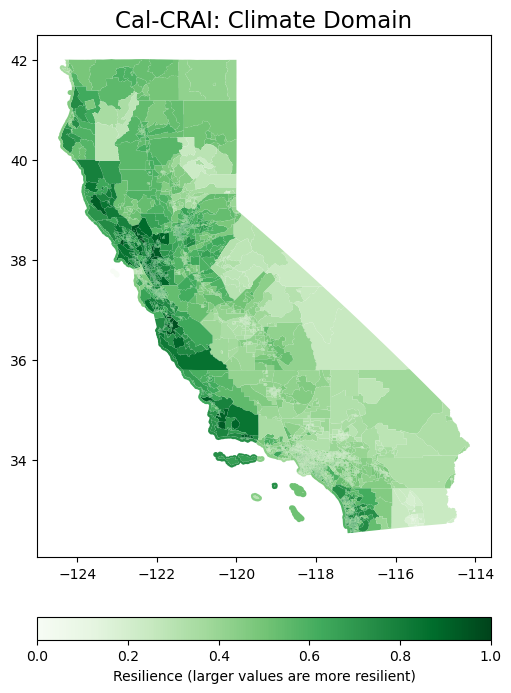

In [37]:
plot_domain(gdf, domain=domain_prefix)

### We can also visualize specific areas!
We call from a the `plot_region_domain` function which has a number of variables:

gdf : GeoDataFrame
    A GeoDataFrame containing the data you want to plot, which must include the column 'GEOID' to match with the census tract data.

counties_to_plot : list of str, optional
    A list of county FIPS codes (as strings) to plot. If None, no counties will be plotted.
    Example: ['037', '071', '065', '029', '111'].

region : str, optional
    A predefined region to plot. Options: 'bay_area', 'central_region', 'inland_deserts', 'north_central', 'northern', or 'south_coast'.
    If specified, this will override `counties_to_plot`.

plot_all : bool, optional
    If True, plots all counties in California. Overrides `counties_to_plot` and `region`.

savefig : bool, optional
    If True, the plot will be saved as a PNG file. Default is False.

font_color : str, optional
    Color of the font for county labels. Default is 'black'.

domain_name : str, optional
    Name of the domain to include in the plot title. Default is 'Society and Economy Domain'.


    Dictionary of county labels
    county_labels = {
        '001': 'Alameda', '003': 'Alpine', '005': 'Amador', '007': 'Butte', '009': 'Calaveras',
        '011': 'Colusa', '013': 'Contra Costa', '015': 'Del Norte', '017': 'El Dorado', '019': 'Fresno',
        '021': 'Glenn', '023': 'Humboldt', '025': 'Imperial', '027': 'Inyo', '029': 'Kern',
        '031': 'Kings', '033': 'Lake', '035': 'Lassen', '037': 'Los Angeles', '039': 'Madera',
        '041': 'Marin', '043': 'Mariposa', '045': 'Mendocino', '047': 'Merced', '049': 'Modoc',
        '051': 'Mono', '053': 'Monterey', '055': 'Napa', '057': 'Nevada', '059': 'Orange',
        '061': 'Placer', '063': 'Plumas', '065': 'Riverside', '067': 'Sacramento', '069': 'San Benito',
        '071': 'San Bernardino', '073': 'San Diego', '075': 'San Francisco', '077': 'San Joaquin',
        '079': 'San Luis Obispo', '081': 'San Mateo', '083': 'Santa Barbara', '085': 'Santa Clara',
        '087': 'Santa Cruz', '089': 'Shasta', '091': 'Sierra', '093': 'Siskiyou', '095': 'Solano',
        '097': 'Sonoma', '099': 'Stanislaus', '101': 'Sutter', '103': 'Tehama', '105': 'Trinity',
        '107': 'Tulare', '109': 'Tuolumne', '111': 'Ventura', '113': 'Yolo', '115': 'Yuba'

You can plot a domains vulnerability index by region, specific county/counties, or the entirety of CA with labels
Below are a few example of each of these plotting scenarios

Number of invalid geometries: 0


KeyError: 'summed_indicators_climate_domain_min_max_standardized'

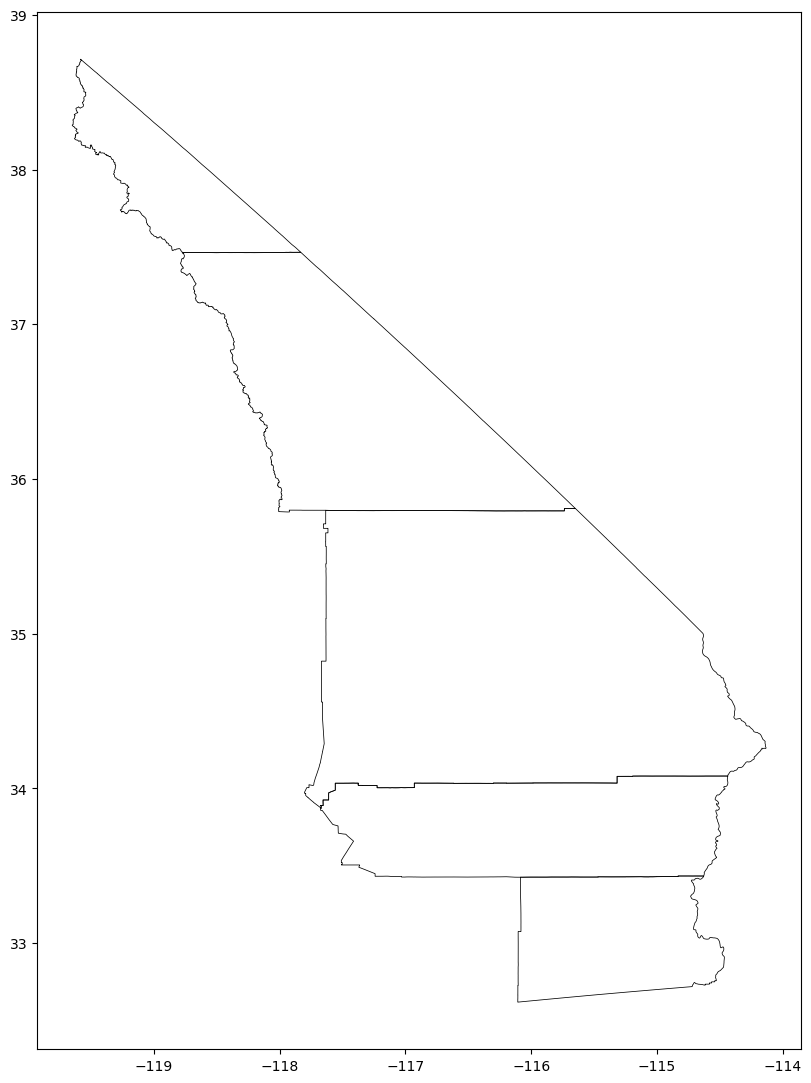

In [38]:
plot_region_domain(min_max_standardized_climate_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix:'Climate Systems Domain'},
                   region='inland_deserts', savefig=False, font_color='black', column_to_plot='all_domain_loss_exposure_product_min_max_standardized')

Number of invalid geometries: 0


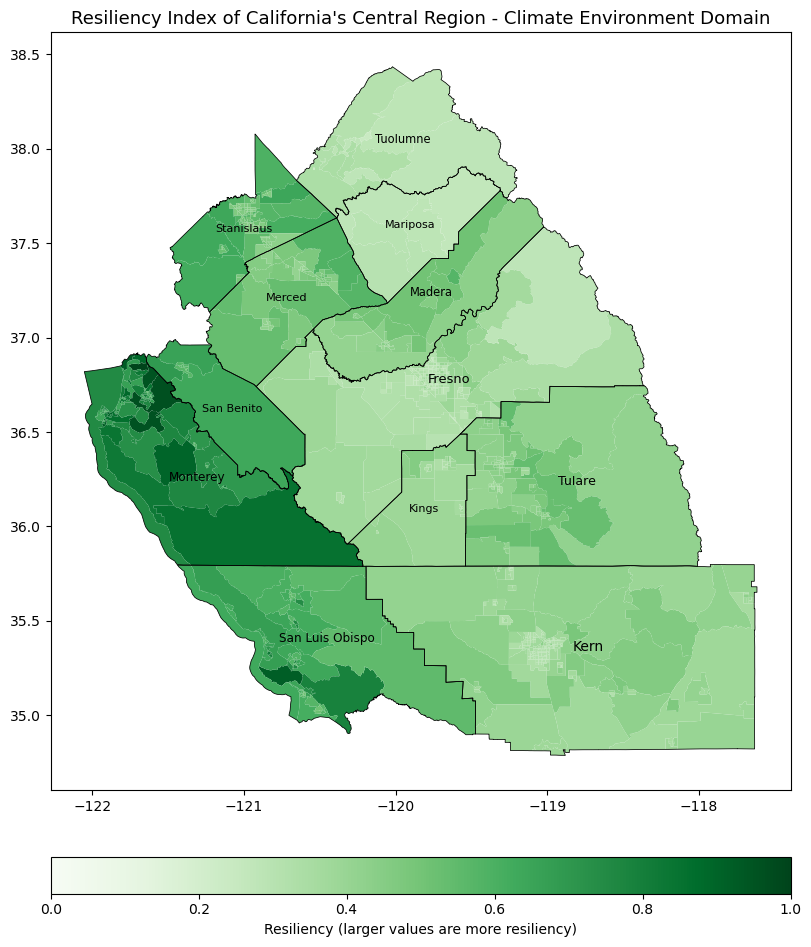

In [39]:
plot_region_domain(min_max_standardized_climate_systems_domain, 
                   domain=domain_prefix, 
                   domain_label_map={domain_prefix: 'Climate Environment Domain'},
                   region='central_region',
                   savefig=False, 
                   font_color='black',
                   column_to_plot = 'all_domain_loss_exposure_product_min_max_standardized')

Number of invalid geometries: 0


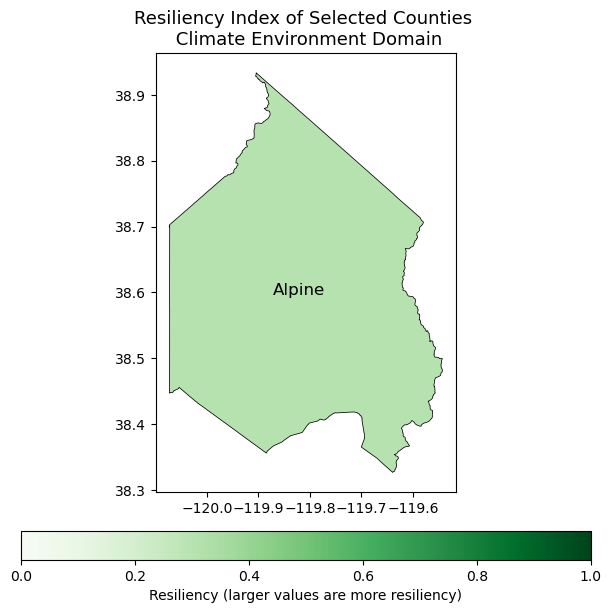

In [40]:
list_of_counties = ['003']
plot_region_domain(min_max_standardized_climate_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Climate Environment Domain'}, counties_to_plot=list_of_counties, savefig=False, font_color='black')

In [37]:
min_max_standardized_climate_systems_domain

,GEOID,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized,just_annual_change_heat_exposure_loss_product_min_max_standardized
0,06001400100,0.753671,0.878232,0.769035,0.546436,0.304982,0.617510,0.960596
1,06001400200,0.704640,0.878232,0.792429,0.605283,0.323460,0.409643,0.955790
2,06001400300,0.764024,0.852784,0.828517,0.605283,0.283089,0.614542,0.955790
3,06001400400,0.702309,0.852784,0.828517,0.605283,0.305819,0.406913,0.955790
4,06001400500,0.781995,0.852784,0.828517,0.605283,0.316931,0.614532,0.955790
...,...,...,...,...,...,...,...,...
9124,06115040902,0.409434,0.324800,0.382787,0.846492,0.000000,0.619160,0.579956
9125,06115041001,0.382023,0.311958,0.374011,0.873744,0.000000,0.527876,0.607368
9126,06115041002,0.396227,0.322660,0.377173,0.819991,0.000000,0.585439,0.581477
9127,06115041101,0.361174,0.353338,0.322773,0.651207,0.000000,0.539505,0.541557


Number of invalid geometries: 0


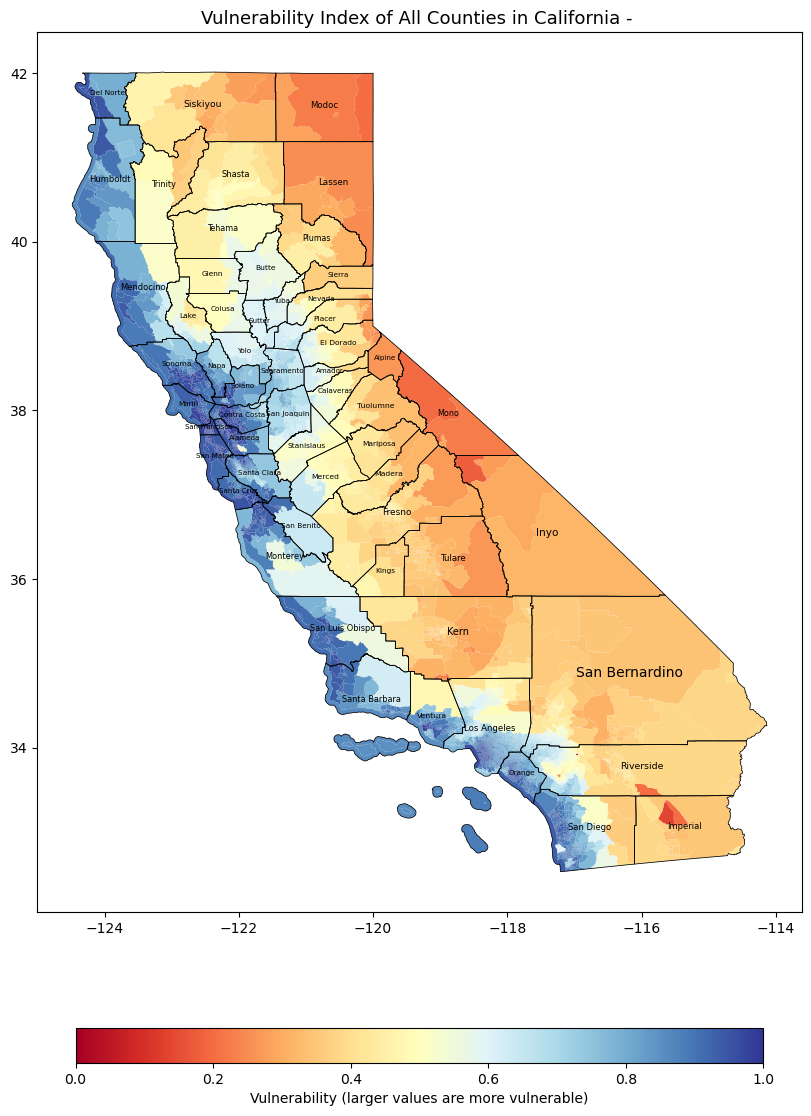

In [41]:
plot_region_domain(min_max_standardized_climate_systems_domain, domain='', domain_label_map={domain_prefix: 'Climate Environment Domain'}, plot_all=True, savefig=False, font_color='black',
                   column_to_plot='just_annual_change_heat_exposure_loss_product_min_max_standardized')

In [43]:
min_max_standardized_climate_systems_domain.to_csv('climate_domain_index_calculation_testing.csv', index=False)

## Step 4: Export the final domain csv file

In [39]:
# set-up file for export
domain_filename = '{}domain_index_calculation.csv'.format(domain_prefix)
gdf.to_csv(domain_filename, index=False)

In [43]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files_upload = indicator_filename, domain_filename

for file in files_upload:
    upload_csv_aws([file], bucket_name, directory)

climate_domain_indicators.csv uploaded to AWS
climate_domain_index_calculation.csv uploaded to AWS
